In [1]:
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [104]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from munch import Munch
from helpers.read_sql import *

from dataclasses import dataclass
from pprint import pprint
import sqlite3
from case_edits.epcase import EneryPlusCaseEditor
from helpers.output_requests import request_sql

import seaborn as sns
from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *

import polars as pl
from datetime import datetime
from ladybug.dt import DateTime


# # Apply the default theme
# sns.set_theme()

In [6]:
case_data = retrieve_cases()
sample_case  = case_data[0]
case_name, idf, sql, path_to_input, path_to_output = sample_case

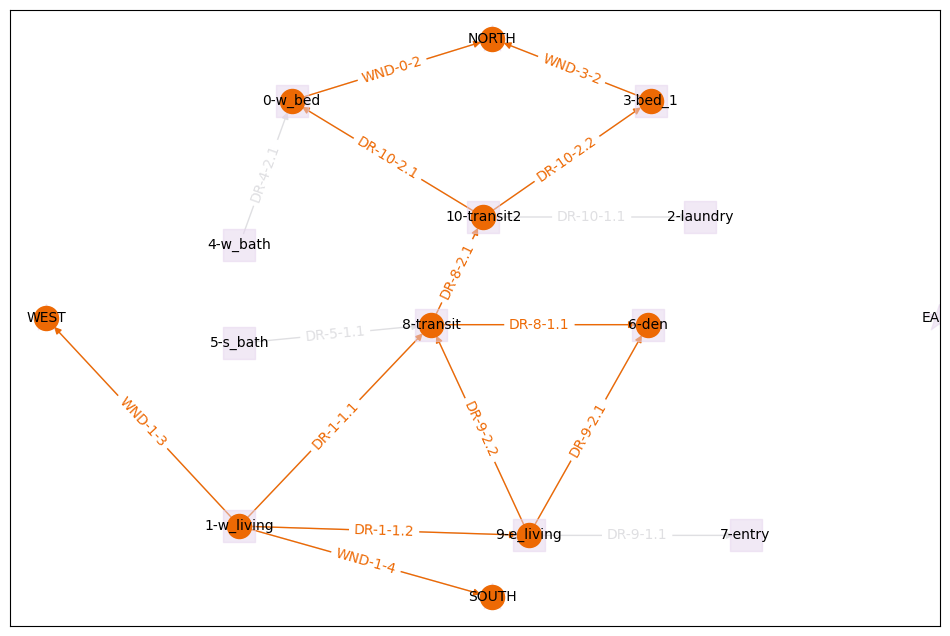

In [65]:
G, pos = create_base_graph(idf, path_to_input)
G_afn = create_afn_graph(idf, G)
f = draw_afn_over_init(G, G_afn, pos)


In [189]:
G_rev =  G.reverse()
G_rev

In [191]:
G_rev.edges[('0-w_bed', '4-w_bath')]

{'surface': 'Block 04 Storey 0 Wall 0002_1',
 'subsurfaces': 'Block 04 Storey 0 Wall 0002_1 Door',
 'stype': 'DOOR'}

In [178]:
qoi4 = all_variables.afn.zone["ach"]
qoi1 = 'AFN Linkage Node 1 to Node 2 Volume Flow Rate'
qoi12 = 'AFN Linkage Node 2 to Node 1 Volume Flow Rate'
curr_qoi = qoi4
df = create_dataframe_for_case(case_name, sql, curr_qoi)
df_vals = df.filter(pl.col("values") > 0 )
print(df.shape, df_vals.shape)
df.head(3)

(1056, 5) (273, 5)


case_names,space_names,qoi,values,datetimes
str,str,str,f64,datetime[μs]
"""amb_b1""","""BLOCK 00 STOREY 0""","""AFN Zone Ventilation Air Chang…",37.348506,2017-07-01 00:00:00
"""amb_b1""","""BLOCK 00 STOREY 0""","""AFN Zone Ventilation Air Chang…",35.148028,2017-07-01 00:15:00
"""amb_b1""","""BLOCK 00 STOREY 0""","""AFN Zone Ventilation Air Chang…",33.594371,2017-07-01 00:30:00


In [183]:
medians = df.group_by(pl.col("space_names")).agg(pl.col("values").median())
filtered_medians = medians.filter(pl.col("values") > 0)
filtered_medians

space_names,values
str,f64
"""BLOCK 01 STOREY 0""",53.616259
"""BLOCK 03 STOREY 0""",70.231091
"""BLOCK 00 STOREY 0""",58.28404


In [166]:
def normalize_to_target(arr:pl.Series, t_min=0, t_max=1):
    # log scale might be better..
    r_min, r_max = arr.min(), arr.max()
    normalize = lambda x: (x - r_min) / (r_max - r_min)
    scale = lambda x: (normalize(x) * (t_max - t_min)) + t_min
    return [scale(i) for i in arr]

In [167]:
def get_matching_edge(G:nx.DiGraph ,subsurface_name:str):
    for e in G.edges:
        if G.edges[e].get("subsurfaces").upper() == subsurface_name:
            return e

In [168]:
values = normalize_to_target(filtered_medians["values"], t_min=1, t_max=4)
edges = [get_matching_edge(G, s) for s in filtered_medians["space_names"]]
values

[2.6767922655015233,
 1.6979725525009672,
 1.7998725131195275,
 2.4704073004332976,
 2.485124360708489,
 2.3265194296386826,
 1.0,
 4.0,
 3.031235698611811,
 2.5201370206600675,
 2.431390508204152]

Text(0.5, 0.98, 'AFN Linkage Node 2 to Node 1 Volume Flow Rate')

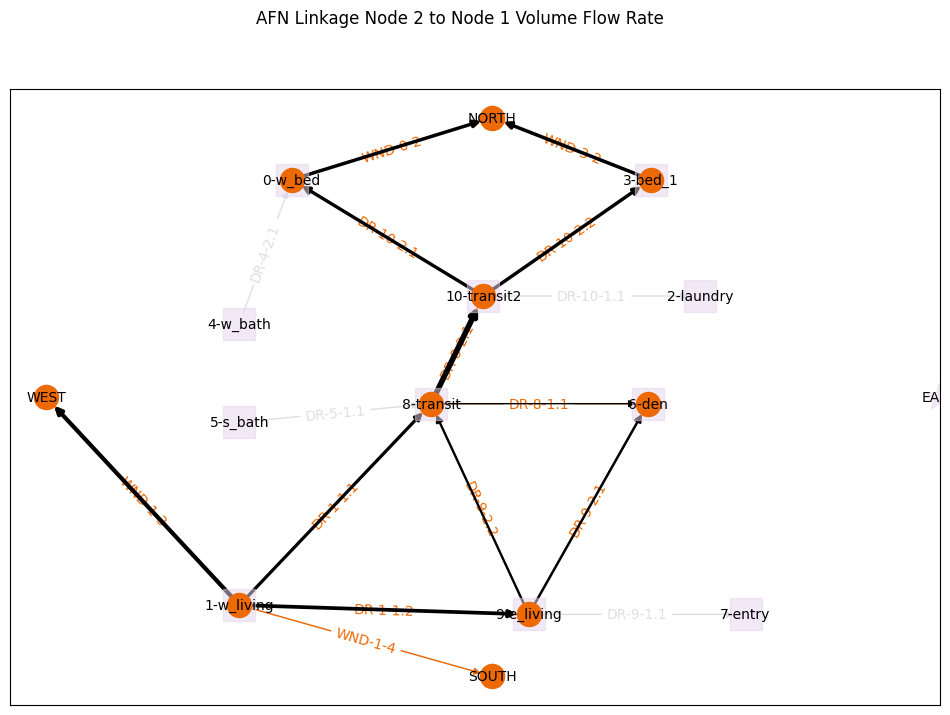

In [169]:
f = draw_afn_over_init(G, G_afn, pos)
patches = nx.draw_networkx_edges(G, pos, edges, values)
f.suptitle(curr_qoi)


In [170]:
type(f)

matplotlib.figure.Figure

In [171]:
G.edges[('0-w_bed', 'NORTH')].get("subsurfaces")

'Block 00 Storey 0 Wall 0002 Window'

In [172]:
get_matching_edge(G, medians["space_names"][0])

('1-w_living', '9-e_living')

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_96133/4038932765.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(df, x="values", hue="space_names", kind="kde")


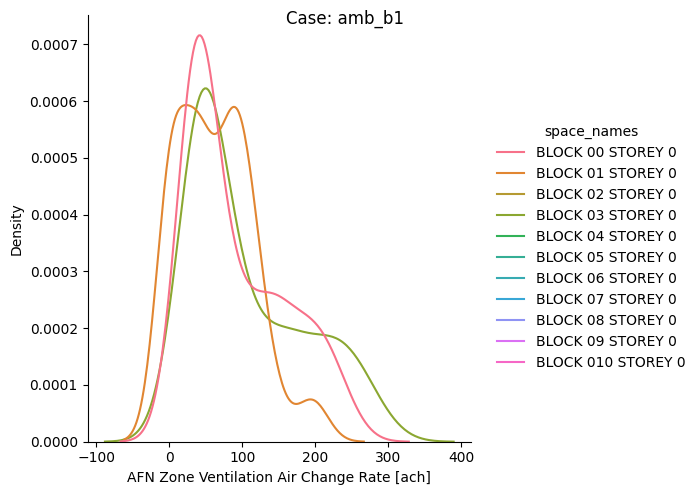

In [180]:
g = sns.displot(df, x="values", hue="space_names", kind="kde")
g = add_displot_labels(g, sample_case, curr_qoi)